# Lesson 6: Event Planner Agent

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [28]:
class AgentState(TypedDict):
    task:str
    venue_plan: str
    logistic_plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [29]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [30]:
VENUE_PLAN_PROMPT = """You are an expert venue planner tasked with planning a high level event. \
Find a venue that meets criteria for an event. expected output is all the details of a specifically chosen \
venue you found to accommodate the event. With a keen sense of space and understanding of event logistics, you excel at finding and securing        "the perfect venue that fits the event's theme, "
size, and budget constraints."""

In [31]:
LOGISTIC_PROMPT = """ you ar a logistic manager. your goal is to Manage all logistics for the event 
including catering and equipments. You need to be Organized and detail-oriented, you ensure that every logistical aspect of the event 
from catering to equipment setup, flawlessly executed to create a seamless experience.

"""

In [32]:
PLANNER_PROMPT = """You are an event planning assistant tasked with plan for a musical event in colombo srilanka.\
Generate the best plan possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [33]:
EDITOR_PROMPT = """You are a editor grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [34]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when planning the following plan. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [35]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [36]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [37]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [38]:
def venue_plan_node(state: AgentState):
    messages = [
        SystemMessage(content=VENUE_PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"venue_plan": response.content}

In [39]:
def logistic_manage_node(state: AgentState):
    messages = [
        SystemMessage(content=LOGISTIC_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"logistic_plan": response.content}

In [40]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [41]:
def planner_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']} \n\n Here is venue plan:\n\n{state['venue_plan']}  \n\n Here is logistic plan:\n\n{state['logistic_plan']}")
    messages = [
        SystemMessage(
            content=PLANNER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [42]:
def editor_node(state: AgentState):
    messages = [
        SystemMessage(content=EDITOR_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [43]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [44]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [45]:
builder = StateGraph(AgentState)

In [46]:
builder.add_node("venue_planner", venue_plan_node)
builder.add_node("logistic_manager", logistic_manage_node)
builder.add_node("generate", planner_node)
builder.add_node("editor", editor_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [47]:
builder.set_entry_point("venue_planner")

In [48]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "editor": "editor"}
)


In [49]:
builder.add_edge("venue_planner", "logistic_manager")
builder.add_edge("logistic_manager", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("editor", "research_critique")
builder.add_edge("research_critique", "generate")

In [50]:
graph = builder.compile(checkpointer=memory)

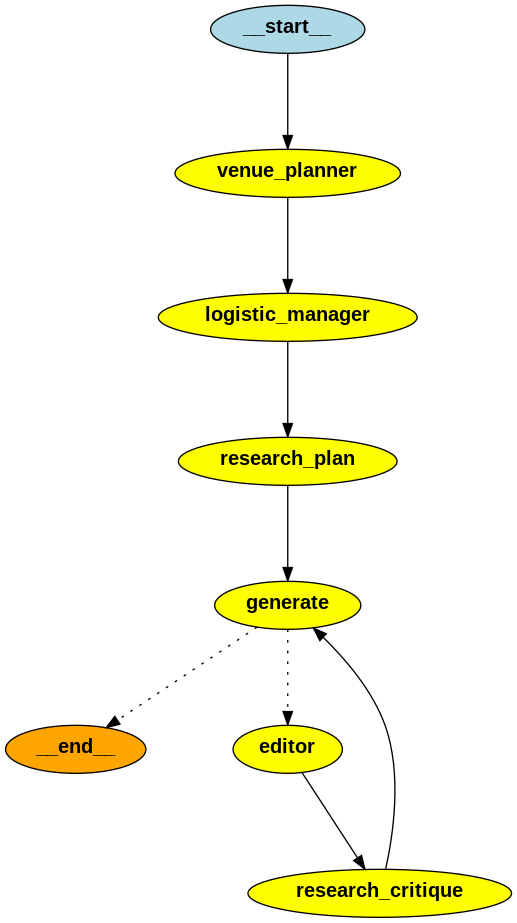

In [51]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "plan for a open ground musical event is colombo, srilanka",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'venue_planner': {'venue_plan': 'For an open ground musical event in Colombo, Sri Lanka, I recommend considering the following venue:\n\n### Venue: Galle Face Green\n\n#### Overview:\nGalle Face Green is a prominent ocean-side urban park that stretches for half a kilometer along the coast in the heart of Colombo. It is one of the most popular and iconic locations in the city, making it an ideal spot for a large-scale musical event.\n\n#### Key Details:\n\n- **Location:** Galle Road, Colombo, Sri Lanka\n- **Capacity:** Can accommodate up to 15,000 people, depending on the setup and stage configuration.\n- **Accessibility:** Easily accessible from various parts of the city with ample public transportation options, including buses and taxis.\n- **Parking:** Limited on-site parking, but additional parking can be arranged in nearby areas.\n- **Facilities:** \n  - Open grassy area suitable for large crowds.\n  - Scenic ocean views providing a picturesque backdrop for the event.\n  - Proximi

{'venue_planner': {'venue_plan': 'For an open ground musical event in Colombo, Sri Lanka, I recommend considering the following venue:\n\n### Venue: Galle Face Green\n\n#### Overview:\nGalle Face Green is a prominent ocean-side urban park that stretches for half a kilometer along the coast in the heart of Colombo. It is one of the most popular and iconic locations in the city, making it an ideal spot for a large-scale musical event.\n\n#### Key Details:\n\n- **Location:** Galle Road, Colombo, Sri Lanka\n- **Capacity:** Can accommodate up to 15,000 people, depending on the setup and stage configuration.\n- **Accessibility:** Easily accessible from various parts of the city with ample public transportation options, including buses and taxis.\n- **Parking:** Limited on-site parking, but additional parking can be arranged in nearby areas.\n- **Facilities:** \n  - Open grassy area suitable for large crowds.\n  - Scenic ocean views providing a picturesque backdrop for the event.\n  - Proximity to hotels, restaurants, and other amenities.\n  - Basic amenities such as restrooms and first aid stations can be arranged.\n\n#### Advantages:\n- **Scenic Location:** The venue offers stunning views of the Indian Ocean, enhancing the overall experience for attendees.\n- **Space:** The large open area allows for flexible stage setups, audience seating, and vendor stalls.\n- **Popularity:** Being a well-known landmark, it can attract a larger audience and adds prestige to the event.\n- **Versatility:** Suitable for various types of musical performances, from rock concerts to classical music festivals.\n\n#### Considerations:\n- **Weather:** As an open ground venue, weather conditions need to be monitored. It is advisable to have contingency plans such as tents or temporary shelters.\n- **Permits:** Necessary permits and approvals from local authorities will be required for hosting the event.\n- **Sound Restrictions:** Being in an urban area, there may be sound level restrictions that need to be adhered to.\n\n#### Budget:\n- **Venue Rental:** Costs can vary based on the duration of the event and specific requirements. It is recommended to contact the Colombo Municipal Council for detailed pricing.\n- **Additional Costs:** Include stage setup, sound and lighting equipment, security, sanitation facilities, and event management services.\n\n#### Contact Information:\n- **Colombo Municipal Council**\n  - **Phone:** +94 11 269 1922\n  - **Email:** info@colombo.mc.gov.lk\n  - **Website:** [Colombo Municipal Council](http://www.colombo.mc.gov.lk/)\n\n### Conclusion:\nGalle Face Green is an excellent choice for an open ground musical event in Colombo, offering a blend of scenic beauty, ample space, and central location. With proper planning and coordination, it can provide a memorable experience for both performers and attendees.'}}
{'logistic_manager': {'logistic_plan': 'Certainly! Planning an open ground musical event involves several key steps to ensure everything runs smoothly. Here’s a comprehensive plan for a musical event in Colombo, Sri Lanka:\n\n### Pre-Event Planning\n\n#### 1. **Venue Selection and Permits**\n   - **Venue:** Select an open ground in Colombo that can accommodate the expected crowd.\n   - **Permits:** Obtain necessary permits from local authorities for hosting the event, including noise permits and public gathering permits.\n\n#### 2. **Budgeting**\n   - **Estimate Costs:** Include costs for venue, equipment, catering, security, marketing, and contingencies.\n   - **Sponsorships:** Seek sponsorships to offset costs.\n\n#### 3. **Date and Time**\n   - **Select Date:** Choose a date that does not clash with other major events in Colombo.\n   - **Time:** Decide on the event duration and schedule.\n\n### Logistics Planning\n\n#### 4. **Catering**\n   - **Vendors:** Select reputable catering vendors who can handle large crowds.\n   - **Menu:** Plan a diverse menu that includes vegetarian, non-vegetarian, and vegan options.\n   - **Beverages:** Ensure a variety of non-alcoholic and alcoholic beverages.\n   - **Setup:** Arrange food stalls or food trucks in a designated area.\n\n#### 5. **Equipment**\n   - **Stage and Sound:** Hire a professional company to set up the stage, sound system, and lighting.\n   - **Power Supply:** Arrange for generators and backup power.\n   - **Seating:** Depending on the event type, arrange for seating or standing areas.\n   - **Restrooms:** Rent portable restrooms and ensure they are well-maintained.\n\n#### 6. **Security and Safety**\n   - **Security Personnel:** Hire a security team to manage crowd control and ensure safety.\n   - **First Aid:** Set up a first aid station with trained medical staff.\n   - **Emergency Exits:** Clearly mark emergency exits and ensure they are accessible.\n\n#### 7. **Transportation and Parking**\n   - **Parking:** Arrange for ample parking space and manage traffic flow.\n   - **Shuttle Services:** Provide shuttle services from key locations if necessary.\n   - **Signage:** Use clear signage for directions and information.\n\n### Event Day Execution\n\n#### 8. **Setup**\n   - **Early Setup:** Begin setup early to ensure everything is in place before the event starts.\n   - **Sound Check:** Conduct sound checks and equipment tests.\n   - **Vendor Coordination:** Ensure all vendors are set up and ready.\n\n#### 9. **Event Management**\n   - **Staff Briefing:** Brief all staff and volunteers on their roles and responsibilities.\n   - **Guest Services:** Set up information booths and help desks.\n   - **Crowd Management:** Monitor crowd flow and manage any issues promptly.\n\n#### 10. **Post-Event**\n   - **Cleanup:** Arrange for a cleanup crew to restore the venue.\n   - **Feedback:** Collect feedback from attendees, vendors, and staff.\n   - **Review:** Conduct a post-event review to identify successes and areas for improvement.\n\n### Additional Considerations\n\n#### 11. **Marketing and Promotion**\n   - **Advertising:** Use social media, local media, and posters to promote the event.\n   - **Ticketing:** Set up an online ticketing system and physical ticket outlets.\n\n#### 12. **Sustainability**\n   - **Waste Management:** Provide recycling bins and manage waste effectively.\n   - **Eco-Friendly Options:** Use biodegradable materials where possible.\n\n#### 13. **Contingency Planning**\n   - **Weather:** Have a plan in place for adverse weather conditions.\n   - **Backup Plans:** Prepare for any unexpected issues with backup plans.\n\nBy following this detailed plan, you can ensure that the musical event in Colombo is a success, providing a memorable experience for all attendees.'}}
{'research_plan': {'content': ['Line Ups, Schedules, Tickets And Concert Events In Colombo. Music to ears is like a soul to life. Escape the monotonous life and find pieces of you by attending live music events, festivals and concerts in Colombo. From classical music to jazz to pop to heavy metal to EDM to rock concerts in Colombo, it is a much complex classification lineup ...', 'Live Music Shows, Tickets & Vanues In Colombo. For the ones whose heart beats for music, live music events are something that you will absolutely enjoy. Groove on the most upbeat songs and enjoy the best of live music in Colombo. You will find music of all kinds and genres, discover the ones that fit your interests and enjoy the spellbinding ...', 'regulations and be accompanied by the fees specified in "schedule V". (2) Receipt of applications, Processing of building applications, charging of relevant Processing fees and issuance of building Permits/approvals to be obtained from Authority for the following activities. i.', 'A modern regulatory and legal framework designed for the international market, to guarantee ease of doing business. Businesses registered within Port City Colombo, are governed by the laws and regulations of the Colombo Port City Economic Commission Act, and thus are privy to unbound financial and business growth advantages of the Special ...', 'This enables us to cater to indoor & outdoor functions. We are delighted and proud to announce that now we are equipped with the world famous brands and latest technology Live Sound Equipment - Music for Live Performance Turbosound + Harman Audio JBL Professional Sound Systems to experience high-quality audio. Call Now: 0 729 729 000.', 'Halogen Lights for Rent 500W. රු 1,000.00 / day. Select date (s) Hot. Lighting Rental, Rent a Tool.', 'Line Ups, Schedules, Tickets And Concert Events In Colombo. Music to ears is like a soul to life. Escape the monotonous life and find pieces of you by attending live music events, festivals and concerts in Colombo. From classical music to jazz to pop to heavy metal to EDM to rock concerts in Colombo, it is a much complex classification lineup ...', 'Stay up-to-date on the latest events and happenings at the Colombo Lotus Tower. From cultural festivals to corporate conferences, our tower is the perfect venue for any occasion. ... Open Arena. Join us for the Colombo Next Level Party with Doctor! ... Lotus Tower Food Festival & Live Music. October 16, 2022 Band Night and DJ Event. October ...', "{'location': {'name': 'Colombo', 'region': 'Western', 'country': 'Sri Lanka', 'lat': 6.93, 'lon': 79.85, 'tz_id': 'Asia/Colombo', 'localtime_epoch': 1717935739, 'localtime': '2024-06-09 17:52'}, 'current': {'last_updated_epoch': 1717935300, 'last_updated': '2024-06-09 17:45', 'temp_c': 30.4, 'temp_f': 86.7, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 15.0, 'wind_kph': 24.1, 'wind_degree': 230, 'wind_dir': 'SW', 'pressure_mb': 1008.0, 'pressure_in': 29.77, 'precip_mm': 0.71, 'precip_in': 0.03, 'humidity': 70, 'cloud': 50, 'feelslike_c': 39.4, 'feelslike_f': 103.0, 'windchill_c': 27.6, 'windchill_f': 81.8, 'heatindex_c': 32.1, 'heatindex_f': 89.8, 'dewpoint_c': 24.6, 'dewpoint_f': 76.4, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 6.0, 'gust_mph': 20.7, 'gust_kph': 33.3}}", "1. Sri Lanka in December is a perfect escape. December is a fantastic time to visit Sri Lanka as the island nation experiences its northeast monsoon, bringing clear skies, sunshine, and pleasant temperatures. It's the ideal weather to explore the rich cultural heritage and lush landscapes of this remarkable country.", '(LANKAPUVATH | COLOMBO) -The Inspector-General of Police CD Wickramaratne has instructed senior police officers to take measures to issue permits for outdoor musical performances. Accordingly, such outdoor musical performances are permitted subject to health guidelines. Outdoor concerts are permitted to be held on Monday through Thursday from 6.00 pm to 10.00 pm and on Fridays and Saturdays ...', 'The Police said that outdoor events are permitted to be held until 10.00 p.m. from Mondays to Thursdays and until 1.00 a.m. on Fridays and Saturdays. Outdoor events are permitted on Sunday until 12.30 a.m. Sound permits will be issued for the respective events by the area Police. (Colombo Gazette) Post Views: 160.']}}
